In [1]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from PIL import Image

from recycle_cnn import CNN


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

trans = transforms.ToTensor()
test_set = torchvision.datasets.ImageFolder('data/test',transform=trans)
test_loader = DataLoader(test_set)

model = torch.load('model.pt')

accuracy: 0.6334106728538283
wrong ans: metal , correct ans: trash


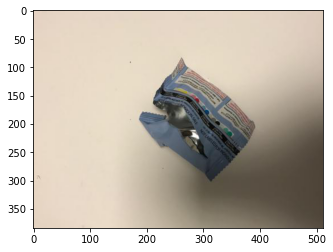

In [3]:
num_correct = 0
to_img_trans = transforms.ToPILImage()
for x, y in test_loader:
    x = x.to(device)
    y = y.to(device)
    
    prediction = torch.argmax(model(x), 1)
    if prediction == y:
        num_correct += 1
    else:
        # print(test_set.classes[prediction], test_set.classes[y])
        wrong_x, wrong_ans, ans = x, test_set.classes[prediction], test_set.classes[y]

accuracy = num_correct / len(test_loader)
print('accuracy:',accuracy)

img = to_img_trans(torch.tensor(wrong_x.cpu().detach().numpy().reshape(3,384,512)))
plt.imshow(img)
print('wrong ans:', wrong_ans, ',','correct ans:', ans)

paper


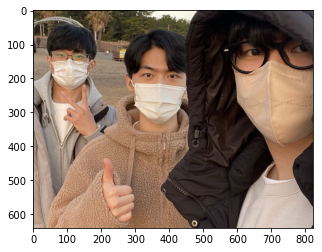

In [4]:
ex_img = Image.open('t.jpg')
plt.imshow(ex_img)
ex_data = transforms.functional.to_tensor(ex_img)
ex_data = transforms.Resize((384,512))(ex_data)
ex_data = ex_data.reshape(1,3,384,512)
result = model(ex_data.to(device))
prediction = torch.argmax(result, 1)
print(test_set.classes[prediction])